In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms,models
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm_notebook
from IPython.core.display import HTML,display
from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,classification_report
from sklearn.metrics import precision_recall_fscore_support as score
import seaborn as sns
import cv2 as cv

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print("Using GPU")
else:
    device = torch.device('cpu')
    print("Using CPU")

Using CPU


In [ ]:
TRAIN_PATH='/kaggle/input/vegetable-image-dataset/Vegetable Images/train'
VALIDATION_PATH='/kaggle/input/vegetable-image-dataset/Vegetable Images/validation'
TEST_PATH='/kaggle/input/vegetable-image-dataset/Vegetable Images/test'

In [ ]:
#Resize image. 
#Apply CenterCrop which is transformation of crop the image by each direction. 
#ToTensor allows converting images to tensors
RESIZE_DIM=224
train_transform = transforms.Compose([
                                     transforms.Resize(RESIZE_DIM),
                                     transforms.CenterCrop(RESIZE_DIM),
                                     transforms.ToTensor()
])

test_transform = transforms.Compose([
                                     transforms.Resize(RESIZE_DIM),
                                     transforms.CenterCrop(RESIZE_DIM),
                                     transforms.ToTensor()
                                     ])

In [ ]:
#Image folder is dataset class that provides a convenient way to load a dataset of images stored in a directory structure 
train_data=torchvision.datasets.ImageFolder(root=TRAIN_PATH,transform=train_transform)
test_data=torchvision.datasets.ImageFolder(root=TEST_PATH,transform=test_transform)
val_data=torchvision.datasets.ImageFolder(root=VALIDATION_PATH,transform=test_transform)

In [ ]:
class_names=train_data.classes
class_names

['Bean',
 'Bitter_Gourd',
 'Bottle_Gourd',
 'Brinjal',
 'Broccoli',
 'Cabbage',
 'Capsicum',
 'Carrot',
 'Cauliflower',
 'Cucumber',
 'Papaya',
 'Potato',
 'Pumpkin',
 'Radish',
 'Tomato']

In [ ]:
#set batch size
BATCH_SIZE=64
numclass=len(class_names)
numclass

15

In [ ]:
#load the data from the ImageFolder dataset in batches
train_dl=DataLoader(train_data,BATCH_SIZE,shuffle=True,num_workers=0)
val_dl=DataLoader(val_data,BATCH_SIZE,shuffle=True,num_workers=0)
test_dl=DataLoader(test_data,BATCH_SIZE,shuffle=False,num_workers=0)

**VGG19 model visualization**

In [ ]:
# load the model
model = models.vgg19(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
weights = []
layers = []
count = 0 

for i in model.children():
    if type(i) == nn.Sequential:
        for j in i:
                if type(j) == nn.Conv2d:
                    count += 1
                    weights.append(j.weight)
                    layers.append(j)
print("Number of convolutional layers:",count)

Number of convolutional layers: 16


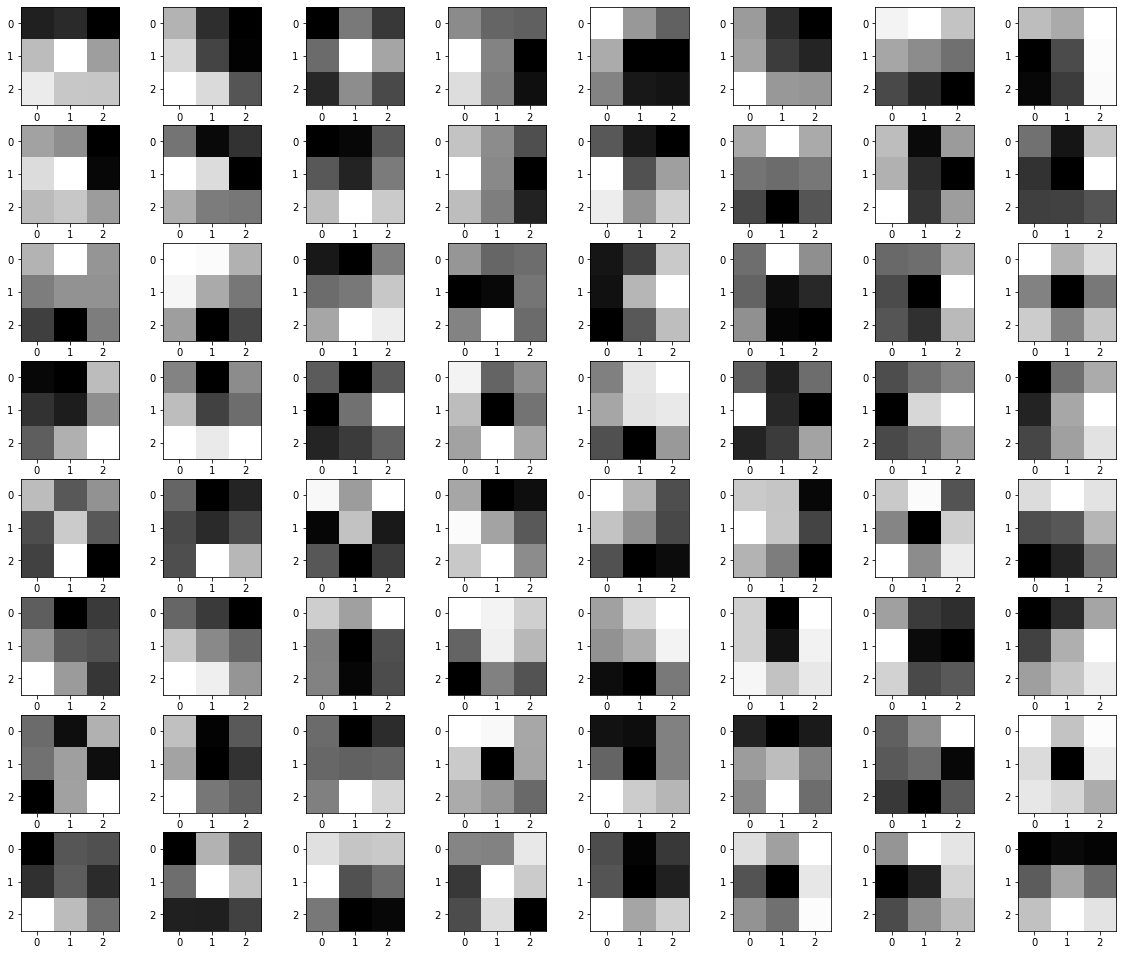

In [ ]:
# visualize the first conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(weights[0]):
    plt.subplot(8, 8, i+1)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
plt.show()

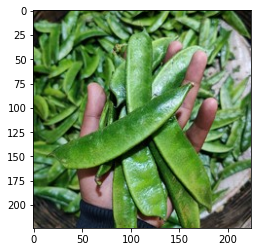

In [ ]:
# read and visualize an image
img = cv.imread(f"/kaggle/input/vegetable-image-dataset/Vegetable Images/test/Bean/0001.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
# define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
img = np.array(img)
img = transform(img)
img = img.unsqueeze(0)

results = [layers[0](img)]
for i in range(1, len(layers)):
    results.append(layers[i](results[-1]))

-------------------------------------------------------------------------------------------------------
Conv Layer-> 1


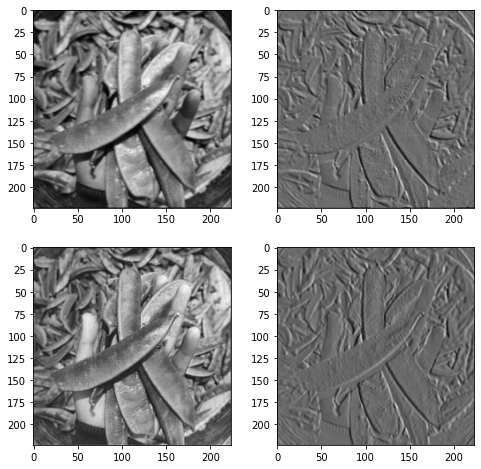

-------------------------------------------------------------------------------------------------------
Conv Layer-> 2


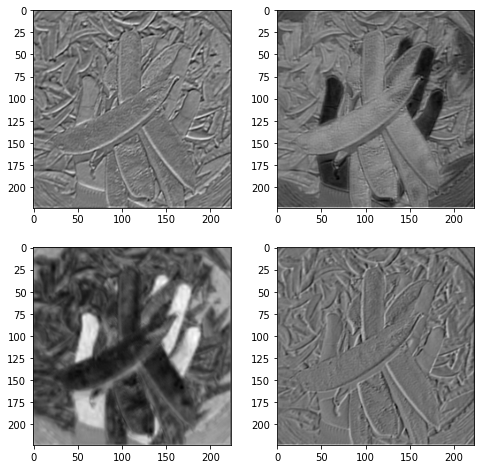

-------------------------------------------------------------------------------------------------------
Conv Layer-> 3


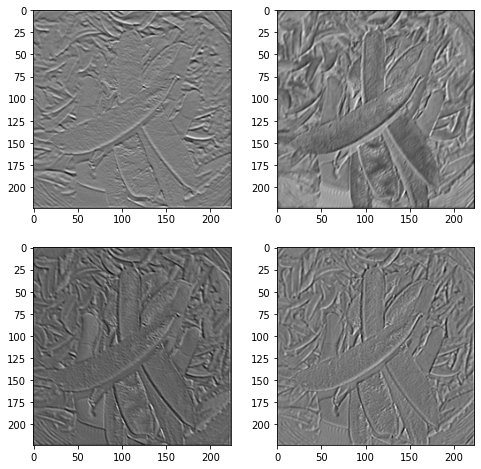

-------------------------------------------------------------------------------------------------------
Conv Layer-> 4


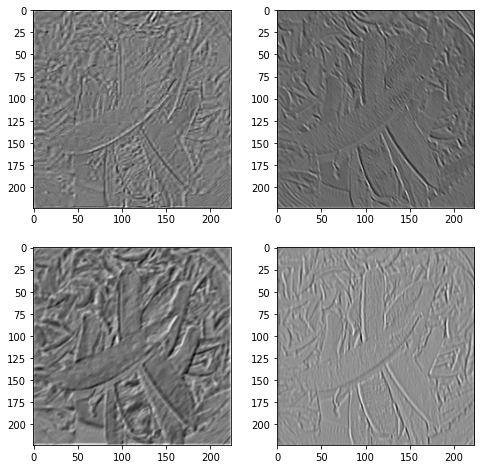

-------------------------------------------------------------------------------------------------------
Conv Layer-> 5


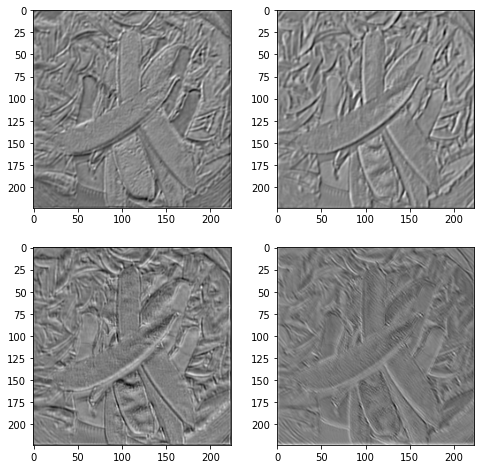

-------------------------------------------------------------------------------------------------------
Conv Layer-> 6


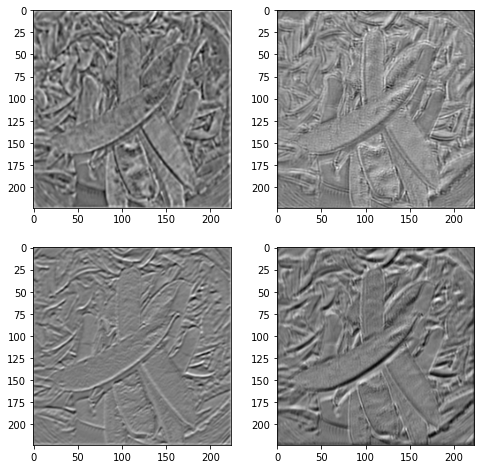

-------------------------------------------------------------------------------------------------------
Conv Layer-> 7


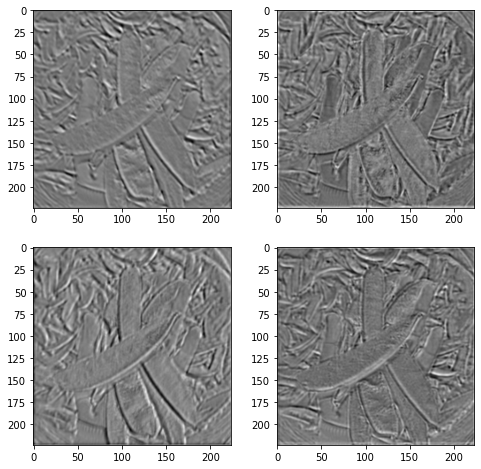

-------------------------------------------------------------------------------------------------------
Conv Layer-> 8


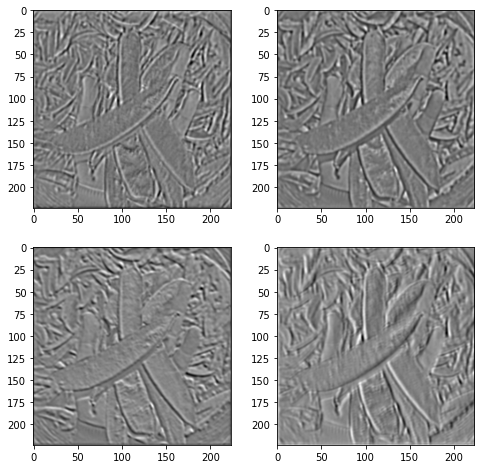

-------------------------------------------------------------------------------------------------------
Conv Layer-> 9


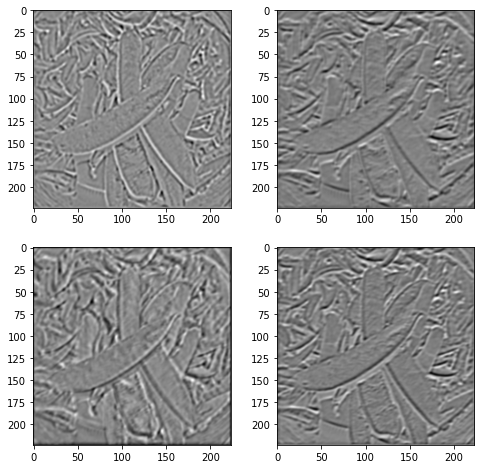

-------------------------------------------------------------------------------------------------------
Conv Layer-> 10


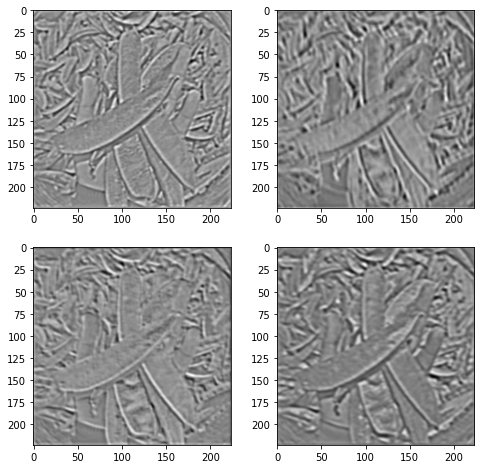

-------------------------------------------------------------------------------------------------------
Conv Layer-> 11


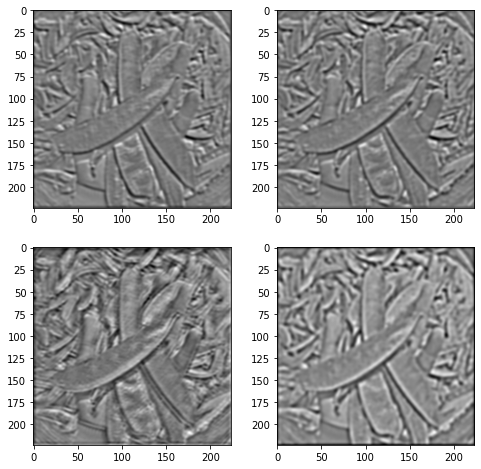

-------------------------------------------------------------------------------------------------------
Conv Layer-> 12


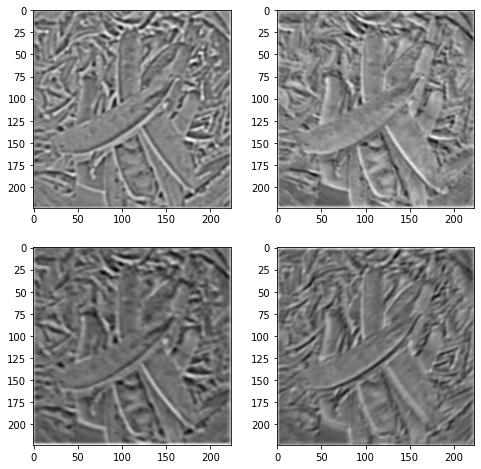

-------------------------------------------------------------------------------------------------------
Conv Layer-> 13


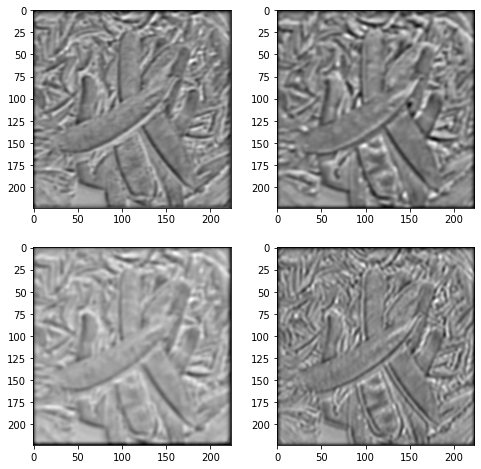

-------------------------------------------------------------------------------------------------------
Conv Layer-> 14


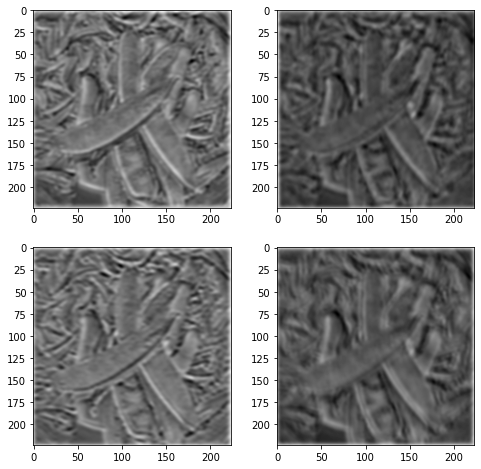

-------------------------------------------------------------------------------------------------------
Conv Layer-> 15


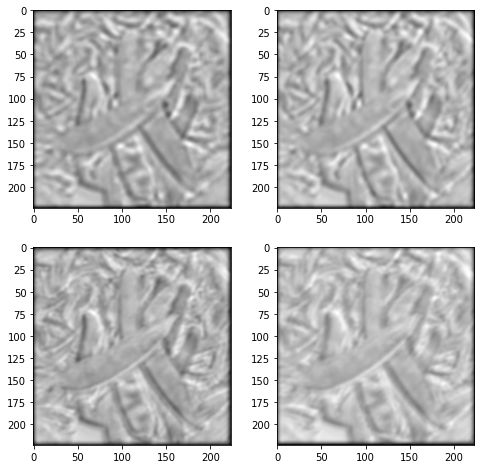

-------------------------------------------------------------------------------------------------------
Conv Layer-> 16


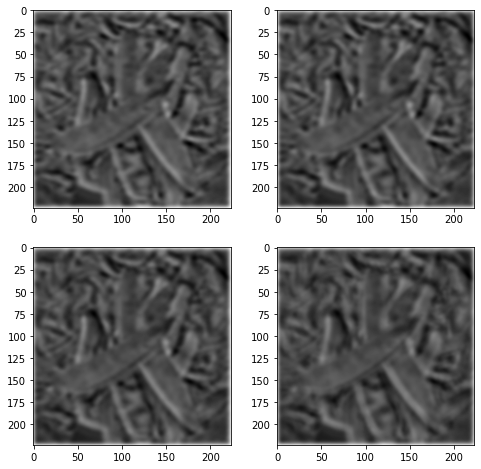

In [ ]:
for num in range(len(results)):
    print("-------------------------------------------------------------------------------------------------------")
    print("Conv Layer->",num+1)
    plt.figure(figsize=(8, 8))
    visualize = results[num][0, :, :, :]
    visualize = visualize.data
    for i, filter in enumerate(visualize):
        if i == 4:
            break
        plt.subplot(2, 2, i + 1)
        plt.imshow(filter, cmap='gray')
        
    plt.show()
    plt.close()

**Functions:**

In [ ]:
#For early stopping this class compare validation loss and train loss
class EarlyStopper:
    def __init__(self, min_delta=0):
        self.min_delta = min_delta

    def early_stop(self, validation_loss,train_loss):
        if validation_loss.item() - train_loss.item() >= self.min_delta:
            print("EarlyStopping!")
            return True
        return False

In [ ]:
def train(model,EPOCHS,train_loader,valid_loader,lossFn,optimizer,scheduler,BATCH_SIZE,early_stop=False):
    model.to(device)
    
    train_losses=[] 
    val_losses=[]
    
    train_acc=[]
    val_acc=[]
    
    estopper=EarlyStopper(0)
    
    for e in range(0, EPOCHS):
        # set the model as train
        model.train()   

        trainLoss = 0
        trainCorrect = 0
        
        #update learning rate with scheduler 
        scheduler.step()
        
        # Print Learning Rate
        print('Epoch:', e+1,'Learning Rate:', scheduler.get_last_lr())
        
        # loop on train data
        with tqdm(train_loader, unit="batch") as tepoch:
            
            count=0
            for x, y in tepoch:
                count+=1
                tepoch.set_description(f"Epoch {e+1}")
                
                # send the input to the device
                (x, y) = (x.to(device), y.to(device)) 

                #forward step
                pred = model(x) 
                
                #calculate train loss
                loss = lossFn(pred, y) 
                
                #zero out the gradients
                optimizer.zero_grad()
                #backpropagation step
                loss.backward()
                #optimizer step
                optimizer.step()
                #add the loss to the total training loss
                trainLoss += loss
                
                #calculate the number of correct predictions
                trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()
                correct = (pred.argmax(1) == y).type(torch.float).sum().item()
                
                #calculate batch accuracy
                accuracy = correct / x.size(0) #divided by length x because the last batch will be different then batch size
                
                #during an epoch printed the batch accuracy
                tepoch.set_postfix(loss=loss.item(), accuracy=100.0 * accuracy)
                
            
            #calculate the average loss
            train_losses.append(trainLoss/count)
            
            #calculate accuracy
            train_acc.append(trainCorrect/len(train_loader.dataset))
            print("Train Accuracy:",trainCorrect/len(train_loader.dataset))
            
            
        valLoss = 0
        valCorrect = 0
        
        with torch.no_grad():
            
            # set the model for evaluation
            model.eval() 
            
            # loop over the test set
            count=0
            for (x, y) in valid_loader:
                count+=1
                (x, y) = (x.to(device), y.to(device))
                
                #forward step
                pred = model(x)
                
                #calculate loss
                loss = lossFn(pred, y) 
                valLoss += loss
                
                #calculate total number of correct predictions
                valCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()
                correct = (pred.argmax(1) == y).type(torch.float).sum().item()
                accuracy = correct / x.size(0)
                
            val_losses.append(valLoss/count)
            val_acc.append(valCorrect/len(valid_loader.dataset))
            print("Validation Accuracy",valCorrect/len(valid_loader.dataset))
        
        #check early stopping every 1 epochs
        if(early_stop and (e+1)%3==0 ):
            print("Early stopping checking")
            print("Validation Loss:",(valLoss/count).item())
            print("Training Loss:",(train_losses[e]).item())
            if(estopper.early_stop(valLoss/count,train_losses[e])):
                break
        print("{}. epoch is finished!".format(e+1))
        print("-"*50)
        
        
    return model,train_losses, val_losses, train_acc, val_acc

In [ ]:
#Plot losses and accuracies of each epoch for compare epoch
def plot_epoch_metric(train_loss, val_loss, train_acc, val_acc):
    x_arr = np.arange(len(train_loss)) + 1
    fig = plt.figure(figsize=(15, 6))
    ax = fig.add_subplot(1, 2, 1)
    
    train_loss_arr=[i.cpu().detach().numpy() for i in train_loss]
    val_loss_arr=[i.cpu().detach().numpy() for i in val_loss]
    
    ax.plot(x_arr, train_loss_arr, '-*', label='Train loss')
    ax.plot(x_arr, val_loss_arr, '--v', label='Validation loss')
    ax.set_title("Loss",size=17)
    ax.legend(fontsize=13)
    
    train_acc_arr=[i for i in train_acc]
    val_acc_arr=[i for i in val_acc]
    
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, train_acc_arr, '-*', label='Train accuracy')
    ax.plot(x_arr, val_acc_arr, '--v',label='Validation accuracy')
    ax.set_title("Accuracy",size=17)
    ax.legend(fontsize=13)
    
    ax.set_xlabel('Epoch', size=13)
    ax.set_ylabel('Accuracy', size=13)
    plt.show()

In [ ]:
#evaluate test dataset with confusion matrix, accuracy, precision, recall and f1-score
def evaluate_test(model,test_dl,loss_fn,labels):
    if torch.cuda.is_available():
        model.cuda()
    
    ground_truth=[]
    predict=[]
    
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_dl):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            
            #get predict classes and corresponding ground truths
            _, preds = torch.max(outputs, 1)
            ground_truth.extend(classes.view(-1).tolist())
            predict.extend(preds.view(-1).tolist())
    
    #calculate accuracies, recalls, precisions and f1-score. Print confusuion matrix.
    conf_matrix = confusion_matrix(y_true=ground_truth, y_pred=predict)
    print('Confusion Matrix:')
    print()
    print(conf_matrix)
    print()
    print(classification_report(ground_truth, predict, digits=3))

# ALL weights include in VGG-19

> **WITHOUT EARLY STOPPING**

In [ ]:
model=models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
#activate layers
layers=[]
for param in model.parameters():
    layers.append(param)
for layer in layers:
    layer.requires_grad=True
for param in model.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
#information of model parameters
print(model.named_parameters)

<bound method Module.named_parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256

In [ ]:
#change length of output 
numFeature = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(numFeature, numclass)
model.classifier[-1] 

Linear(in_features=4096, out_features=15, bias=True)

In [ ]:
# adding loss function and optimizer to the model
loss_fun=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

#decrease learning rate factor of 0.1 every 5 step 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
#Without Early stopping
num_epochs=15
model,train_losses, val_losses, train_acc, val_acc=train(model,num_epochs,train_dl,val_dl,loss_fun,optimizer,scheduler,BATCH_SIZE)

/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch: 1 Learning Rate: [0.001]


Epoch 1: 100%|██████████| 235/235 [06:26<00:00,  1.64s/batch, accuracy=29.2, loss=2.09]


Train Accuracy: 0.151
Validation Accuracy 0.30466666666666664
1. epoch is finished!
--------------------------------------------------
Epoch: 2 Learning Rate: [0.001]


Epoch 2: 100%|██████████| 235/235 [04:55<00:00,  1.26s/batch, accuracy=37.5, loss=1.46]


Train Accuracy: 0.42406666666666665
Validation Accuracy 0.532
2. epoch is finished!
--------------------------------------------------
Epoch: 3 Learning Rate: [0.001]


Epoch 3: 100%|██████████| 235/235 [04:55<00:00,  1.26s/batch, accuracy=62.5, loss=0.805]


Train Accuracy: 0.6172666666666666
Validation Accuracy 0.7116666666666667
3. epoch is finished!
--------------------------------------------------
Epoch: 4 Learning Rate: [0.001]


Epoch 4: 100%|██████████| 235/235 [04:54<00:00,  1.25s/batch, accuracy=95.8, loss=0.203]


Train Accuracy: 0.7307333333333333
Validation Accuracy 0.7876666666666666
4. epoch is finished!
--------------------------------------------------
Epoch: 5 Learning Rate: [0.0001]


Epoch 5: 100%|██████████| 235/235 [04:54<00:00,  1.25s/batch, accuracy=91.7, loss=0.581]


Train Accuracy: 0.8613333333333333
Validation Accuracy 0.8833333333333333
5. epoch is finished!
--------------------------------------------------
Epoch: 6 Learning Rate: [0.0001]


Epoch 6: 100%|██████████| 235/235 [04:55<00:00,  1.26s/batch, accuracy=100, loss=0.154] 


Train Accuracy: 0.8958666666666667
Validation Accuracy 0.893
6. epoch is finished!
--------------------------------------------------
Epoch: 7 Learning Rate: [0.0001]


Epoch 7: 100%|██████████| 235/235 [04:56<00:00,  1.26s/batch, accuracy=83.3, loss=0.408] 


Train Accuracy: 0.9133333333333333
Validation Accuracy 0.913
7. epoch is finished!
--------------------------------------------------
Epoch: 8 Learning Rate: [0.0001]


Epoch 8: 100%|██████████| 235/235 [04:54<00:00,  1.25s/batch, accuracy=100, loss=0.0837] 


Train Accuracy: 0.9308
Validation Accuracy 0.922
8. epoch is finished!
--------------------------------------------------
Epoch: 9 Learning Rate: [0.0001]


Epoch 9: 100%|██████████| 235/235 [04:54<00:00,  1.25s/batch, accuracy=95.8, loss=0.201] 


Train Accuracy: 0.943
Validation Accuracy 0.9296666666666666
9. epoch is finished!
--------------------------------------------------
Epoch: 10 Learning Rate: [1e-05]


Epoch 10: 100%|██████████| 235/235 [04:55<00:00,  1.26s/batch, accuracy=91.7, loss=0.128] 


Train Accuracy: 0.9604666666666667
Validation Accuracy 0.934
10. epoch is finished!
--------------------------------------------------
Epoch: 11 Learning Rate: [1e-05]


Epoch 11: 100%|██████████| 235/235 [05:04<00:00,  1.30s/batch, accuracy=91.7, loss=0.272] 


Train Accuracy: 0.9646666666666667
Validation Accuracy 0.9366666666666666
11. epoch is finished!
--------------------------------------------------
Epoch: 12 Learning Rate: [1e-05]


Epoch 12: 100%|██████████| 235/235 [04:57<00:00,  1.27s/batch, accuracy=100, loss=0.0558] 


Train Accuracy: 0.9666
Validation Accuracy 0.9376666666666666
12. epoch is finished!
--------------------------------------------------
Epoch: 13 Learning Rate: [1e-05]


Epoch 13: 100%|██████████| 235/235 [05:01<00:00,  1.28s/batch, accuracy=95.8, loss=0.125] 


Train Accuracy: 0.9661333333333333
Validation Accuracy 0.9383333333333334
13. epoch is finished!
--------------------------------------------------
Epoch: 14 Learning Rate: [1e-05]


Epoch 14: 100%|██████████| 235/235 [04:59<00:00,  1.27s/batch, accuracy=95.8, loss=0.172] 


Train Accuracy: 0.9676
Validation Accuracy 0.939
14. epoch is finished!
--------------------------------------------------
Epoch: 15 Learning Rate: [1.0000000000000002e-06]


Epoch 15: 100%|██████████| 235/235 [05:06<00:00,  1.31s/batch, accuracy=100, loss=0.017]  


Train Accuracy: 0.9706666666666667
Validation Accuracy 0.939
15. epoch is finished!
--------------------------------------------------


In [ ]:
#save model
torch.save(model.state_dict(),'weights1.pt')

Our model approached 100% accuracy, but it started to become overfit at 90% accuracy. 

Loss showed overfit after 0.4 loss.

In other words, there is an overfit condition observed after the 6th epoch

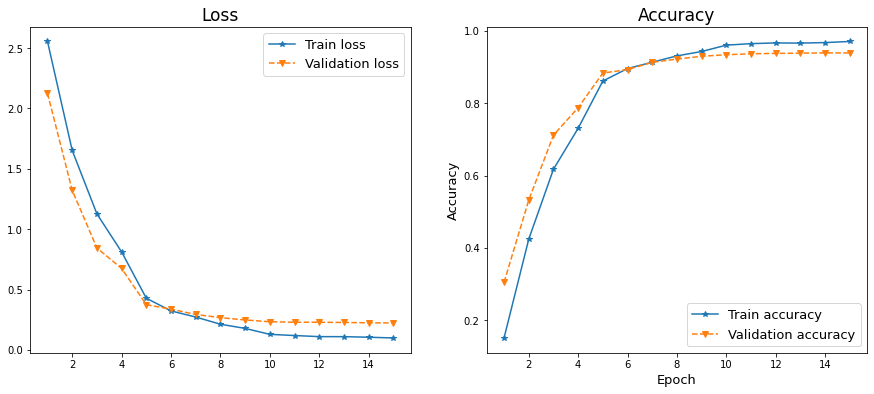

In [ ]:
plot_epoch_metric(train_losses, val_losses, train_acc, val_acc)

The model performed best on the 7th class. but overall it achieved precision recall f1 score and accuracy over 90%. This shows that overfitting is still not much.

The **best** class is **carrot**. F1 score -> 0.987

The **worst** class is **cabbage**. F1 score -> 0.888

The accuracy is lower than train accuracy and same as validation accuracy.

In [ ]:
evaluate_test(model,test_dl,loss_fun,class_names)

Confusion Matrix:

[[181   0   1   3   0   5   0   0   2   6   0   1   0   0   1]
 [  0 192   0   0   1   0   0   0   0   1   0   0   6   0   0]
 [  0   0 198   0   0   0   1   0   0   0   1   0   0   0   0]
 [  2   0   0 184   0   2   0   0   0   6   3   0   1   0   2]
 [  0   0   0   1 192   4   0   0   3   0   0   0   0   0   0]
 [  4   0   0   1   1 183   0   0   7   3   0   0   1   0   0]
 [  1   0   3   0   0   0 193   0   0   0   3   0   0   0   0]
 [  0   0   0   0   0   0   1 196   0   0   0   3   0   0   0]
 [  1   0   0   0   1   4   0   0 187   4   0   1   1   0   1]
 [  2   3   2   8   0   3   0   0   0 179   1   0   2   0   0]
 [  0   0   3   1   0   0   1   0   0   1 192   0   1   0   1]
 [  0   0   0   0   0   0   1   0   0   0   0 199   0   0   0]
 [  0   5   0   2   7   7   0   0   2   2   0   0 173   0   2]
 [  2   0   0   0   0   0   1   0   0   0   0   0   1 195   1]
 [  3   0   0   5   0   4   2   1   1   0   1   1   3   4 175]]

              precision    recall 

>**WITH EARLY STOPPING**

In [ ]:
model=models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
#activate layers 
layers=[]
for param in model.parameters():
    layers.append(param)
for layer in layers:
    layer.requires_grad=True
for param in model.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
#change length of output 
numFeature = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(numFeature, numclass)
model.classifier[-1] 

Linear(in_features=4096, out_features=15, bias=True)

In [ ]:
# adding loss function and optimizer to the model
loss_fun=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

#decrease learning rate factor of 0.1 every 5 step 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
#With Early stopping
num_epochs=15
model,train_losses, val_losses, train_acc, val_acc=train(model,num_epochs,train_dl,val_dl,loss_fun,optimizer,scheduler,BATCH_SIZE,early_stop=True)

Epoch: 1 Learning Rate: [0.001]


Epoch 1: 100%|██████████| 235/235 [05:30<00:00,  1.41s/batch, accuracy=45.8, loss=1.43]


Train Accuracy: 0.21073333333333333
Validation Accuracy 0.3506666666666667
1. epoch is finished!
--------------------------------------------------
Epoch: 2 Learning Rate: [0.001]


Epoch 2: 100%|██████████| 235/235 [05:00<00:00,  1.28s/batch, accuracy=41.7, loss=1.15] 


Train Accuracy: 0.47346666666666665
Validation Accuracy 0.6436666666666667
2. epoch is finished!
--------------------------------------------------
Epoch: 3 Learning Rate: [0.001]


Epoch 3: 100%|██████████| 235/235 [05:03<00:00,  1.29s/batch, accuracy=70.8, loss=0.708]


Train Accuracy: 0.6525333333333333
Validation Accuracy 0.773
Early stopping checking
Validation Loss: 0.639491617679596
Training Loss: 0.974204421043396
3. epoch is finished!
--------------------------------------------------
Epoch: 4 Learning Rate: [0.0001]


Epoch 4: 100%|██████████| 235/235 [05:00<00:00,  1.28s/batch, accuracy=87.5, loss=0.308]


Train Accuracy: 0.8365333333333334
Validation Accuracy 0.8756666666666667
4. epoch is finished!
--------------------------------------------------
Epoch: 5 Learning Rate: [0.0001]


Epoch 5: 100%|██████████| 235/235 [04:59<00:00,  1.27s/batch, accuracy=75, loss=0.646]  


Train Accuracy: 0.8871333333333333
Validation Accuracy 0.9083333333333333
5. epoch is finished!
--------------------------------------------------
Epoch: 6 Learning Rate: [0.0001]


Epoch 6: 100%|██████████| 235/235 [04:58<00:00,  1.27s/batch, accuracy=75, loss=0.513]  


Train Accuracy: 0.9161333333333334
Validation Accuracy 0.9233333333333333
Early stopping checking
Validation Loss: 0.24722743034362793
Training Loss: 0.2573215961456299
6. epoch is finished!
--------------------------------------------------
Epoch: 7 Learning Rate: [0.0001]


Epoch 7: 100%|██████████| 235/235 [04:58<00:00,  1.27s/batch, accuracy=95.8, loss=0.149] 


Train Accuracy: 0.9382
Validation Accuracy 0.938
7. epoch is finished!
--------------------------------------------------
Epoch: 8 Learning Rate: [0.0001]


Epoch 8: 100%|██████████| 235/235 [04:59<00:00,  1.27s/batch, accuracy=87.5, loss=0.509] 


Train Accuracy: 0.9542
Validation Accuracy 0.9473333333333334
8. epoch is finished!
--------------------------------------------------
Epoch: 9 Learning Rate: [1e-05]


Epoch 9: 100%|██████████| 235/235 [05:00<00:00,  1.28s/batch, accuracy=100, loss=0.0495] 


Train Accuracy: 0.9741333333333333
Validation Accuracy 0.9546666666666667
Early stopping checking
Validation Loss: 0.16006587445735931
Training Loss: 0.08485811203718185
EarlyStopping!


In [ ]:
#save model
torch.save(model.state_dict(),'weights2.pt')

Overfitting was observed after the 7th epoch. Our Early stopping system checks for overfitting every 3 epochs. Here, in the 9th epoch, education was stopped.

The reason for the difference in the loss and accuracy values compared to the previous model is completely related to the different mixing of the train dataset.

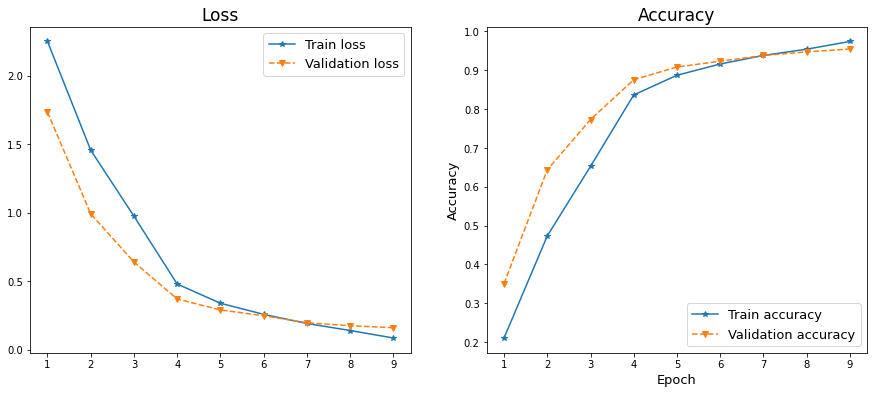

In [ ]:
plot_epoch_metric(train_losses, val_losses, train_acc, val_acc)

The model performed best on the 7th class. but overall it achieved precision recall f1 score and accuracy over 93%. This shows that overfitting is still not much.

The **best** class is **carrot**. F1 score -> 0.993

The **worst** class is **pumpkin**. F1 score -> 0.912

In here accuray is higher than validation accuracy however lower than training accuracy. If we compare this accuracy with "Without early stopping" model accuracy this one is better.

In [ ]:
evaluate_test(model,test_dl,loss_fun,class_names)

Confusion Matrix:

[[196   0   0   1   0   3   0   0   0   0   0   0   0   0   0]
 [  0 197   0   0   1   0   0   0   1   0   0   0   0   1   0]
 [  0   0 197   0   0   0   0   0   0   0   3   0   0   0   0]
 [  2   0   2 188   0   1   0   0   0   5   2   0   0   0   0]
 [  1   1   0   2 187   6   0   0   2   0   0   0   1   0   0]
 [  0   0   0   0   0 196   0   0   1   0   0   0   3   0   0]
 [  0   0   1   1   0   0 194   2   0   0   2   0   0   0   0]
 [  0   0   0   0   0   0   0 200   0   0   0   0   0   0   0]
 [  1   1   0   0   0   1   0   0 182   0   0   1   9   2   3]
 [  5   0   0   7   0   1   0   0   1 185   0   0   1   0   0]
 [  0   0   1   1   0   0   1   0   0   0 196   0   0   0   1]
 [  0   0   0   0   0   0   0   0   0   0   0 197   0   3   0]
 [  0   2   0   1   4   1   2   0   6   0   0   0 181   0   3]
 [  0   0   0   0   0   0   0   0   1   0   0   5   0 194   0]
 [  1   0   2   5   0   0   5   1   3   0   0   0   2   1 180]]

              precision    recall 

#  Only fully connected of VGG-19

> WITHOUT EARLY STOPPING

In [ ]:
model=models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
#
layers=[]
for param in model.parameters():
    layers.append(param)
for layer in layers:
    layer.requires_grad=False
for param in model.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [ ]:
#change length of output 
numFeature = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(numFeature, numclass)
model.classifier[-1]

In [ ]:
model.classifier #FC

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=15, bias=True)
)

In [ ]:
# adding loss function and optimizer to the model
loss_fun=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

# Decrease learning rate factor of 0.1 every 5 step 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
num_epochs=15
model,train_losses, val_losses, train_acc, val_acc=train(model,num_epochs,train_dl,val_dl,loss_fun,optimizer,scheduler,BATCH_SIZE)

/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch: 1 Learning Rate: [0.001]


Epoch 1: 100%|██████████| 235/235 [02:54<00:00,  1.35batch/s, accuracy=91.7, loss=0.127] 


Train Accuracy: 0.9366
Validation Accuracy 0.985
1. epoch is finished!
--------------------------------------------------
Epoch: 2 Learning Rate: [0.001]


Epoch 2: 100%|██████████| 235/235 [02:07<00:00,  1.85batch/s, accuracy=95.8, loss=0.125] 


Train Accuracy: 0.9805333333333334
Validation Accuracy 0.9883333333333333
2. epoch is finished!
--------------------------------------------------
Epoch: 3 Learning Rate: [0.001]


Epoch 3: 100%|██████████| 235/235 [02:08<00:00,  1.83batch/s, accuracy=100, loss=0.0125] 


Train Accuracy: 0.9853333333333333
Validation Accuracy 0.99
3. epoch is finished!
--------------------------------------------------
Epoch: 4 Learning Rate: [0.001]


Epoch 4: 100%|██████████| 235/235 [02:09<00:00,  1.81batch/s, accuracy=100, loss=0.0176] 


Train Accuracy: 0.9878
Validation Accuracy 0.9926666666666667
4. epoch is finished!
--------------------------------------------------
Epoch: 5 Learning Rate: [0.0001]


Epoch 5: 100%|██████████| 235/235 [02:08<00:00,  1.83batch/s, accuracy=100, loss=0.0166] 


Train Accuracy: 0.9893333333333333
Validation Accuracy 0.9933333333333333
5. epoch is finished!
--------------------------------------------------
Epoch: 6 Learning Rate: [0.0001]


Epoch 6: 100%|██████████| 235/235 [02:08<00:00,  1.83batch/s, accuracy=100, loss=0.00877]


Train Accuracy: 0.9902
Validation Accuracy 0.9943333333333333
6. epoch is finished!
--------------------------------------------------
Epoch: 7 Learning Rate: [0.0001]


Epoch 7: 100%|██████████| 235/235 [02:08<00:00,  1.83batch/s, accuracy=100, loss=0.0216] 


Train Accuracy: 0.992
Validation Accuracy 0.9936666666666667
7. epoch is finished!
--------------------------------------------------
Epoch: 8 Learning Rate: [0.0001]


Epoch 8: 100%|██████████| 235/235 [02:08<00:00,  1.83batch/s, accuracy=100, loss=0.0128] 


Train Accuracy: 0.9912
Validation Accuracy 0.9936666666666667
8. epoch is finished!
--------------------------------------------------
Epoch: 9 Learning Rate: [0.0001]


Epoch 9: 100%|██████████| 235/235 [02:08<00:00,  1.82batch/s, accuracy=100, loss=0.0126] 


Train Accuracy: 0.9921333333333333
Validation Accuracy 0.9946666666666667
9. epoch is finished!
--------------------------------------------------
Epoch: 10 Learning Rate: [1e-05]


Epoch 10: 100%|██████████| 235/235 [02:08<00:00,  1.82batch/s, accuracy=95.8, loss=0.103] 


Train Accuracy: 0.9924666666666667
Validation Accuracy 0.994
10. epoch is finished!
--------------------------------------------------
Epoch: 11 Learning Rate: [1e-05]


Epoch 11: 100%|██████████| 235/235 [02:07<00:00,  1.84batch/s, accuracy=95.8, loss=0.0885]


Train Accuracy: 0.993
Validation Accuracy 0.9943333333333333
11. epoch is finished!
--------------------------------------------------
Epoch: 12 Learning Rate: [1e-05]


Epoch 12: 100%|██████████| 235/235 [02:07<00:00,  1.84batch/s, accuracy=100, loss=0.0111] 


Train Accuracy: 0.9930666666666667
Validation Accuracy 0.9943333333333333
12. epoch is finished!
--------------------------------------------------
Epoch: 13 Learning Rate: [1e-05]


Epoch 13: 100%|██████████| 235/235 [02:08<00:00,  1.83batch/s, accuracy=100, loss=0.00507]


Train Accuracy: 0.992
Validation Accuracy 0.994
13. epoch is finished!
--------------------------------------------------
Epoch: 14 Learning Rate: [1e-05]


Epoch 14: 100%|██████████| 235/235 [02:08<00:00,  1.84batch/s, accuracy=100, loss=0.061]  


Train Accuracy: 0.9932666666666666
Validation Accuracy 0.994
14. epoch is finished!
--------------------------------------------------
Epoch: 15 Learning Rate: [1.0000000000000002e-06]


Epoch 15: 100%|██████████| 235/235 [02:08<00:00,  1.84batch/s, accuracy=100, loss=0.00473]


Train Accuracy: 0.9929333333333333
Validation Accuracy 0.994
15. epoch is finished!
--------------------------------------------------


Loss and accuracy are very high. In addition, when we compare the validation accuracy with the Trainin accuracy, there is no overfitting situation. In addition, these models, which include only fully connected, worked better than our first two models, that is, trainings involving all layers.  

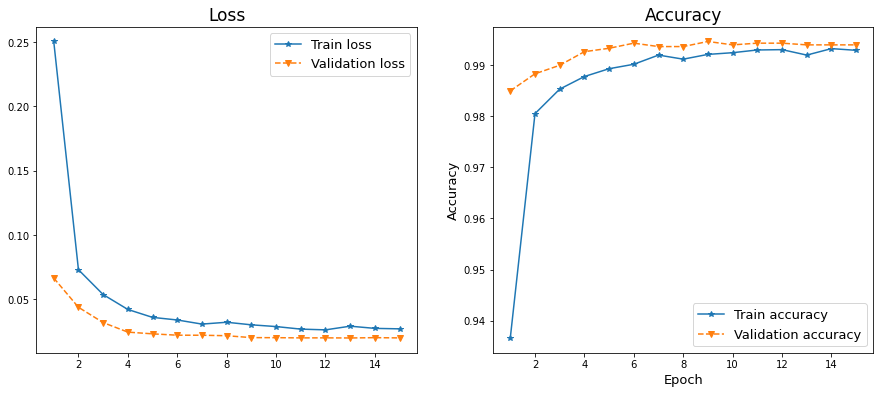

In [ ]:
plot_epoch_metric(train_losses, val_losses, train_acc, val_acc)

Looking at the test evaluation, it achieved better accuracy than Train and Validation accuracy. So our model works really well. We get almost 100% accuracy.
Besides these, there are values ​​with **f1 score of 1**. They were predicted 100% correctly on the test set.

These:
**Bottle_Gourd, Carrot, Potato, Radish** are classes.

The worst are **Brinjal and Papaya** classes with an **F1 score of 0.99**. But of course, it would be very wrong to call the value of 99% bad. The bad among the good.


In [ ]:
evaluate_test(model,test_dl,loss_fun,class_names)

Confusion Matrix:

[[200   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 198   0   0   0   0   0   0   0   1   0   0   1   0   0]
 [  0   0 200   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 198   0   0   0   0   0   1   1   0   0   0   0]
 [  0   0   0   0 198   1   0   0   1   0   0   0   0   0   0]
 [  0   0   0   1   0 198   0   0   1   0   0   0   0   0   0]
 [  0   0   0   0   0   0 200   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 200   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 200   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   1 199   0   0   0   0   0]
 [  0   0   0   0   0   0   1   0   0   0 199   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 200   0   0   0]
 [  0   0   0   1   0   0   1   0   1   0   0   0 197   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 200   0]
 [  1   0   0   0   0   0   0   0   0   0   0   0   0   0 199]]

              precision    recall 

In [ ]:
torch.save(model.state_dict(),'weights3.pt')

> WITH EARLY STOPPING

In [ ]:
model=models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
#drop layers other then fully connected
layers=[]
for param in model.parameters():
    layers.append(param)
for layer in layers:
    layer.requires_grad=False
for param in model.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [ ]:
#change length of output 
numFeature = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(numFeature, numclass)
model.classifier[-1] 

Linear(in_features=4096, out_features=15, bias=True)

In [ ]:
model.classifier #FC

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=15, bias=True)
)

In [ ]:
# adding loss function and optimizer to the model
loss_fun=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

# Decrease learning rate factor of 0.1 every 5 step 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
num_epochs=15
model,train_losses, val_losses, train_acc, val_acc=train(model,num_epochs,train_dl,val_dl,loss_fun,optimizer,scheduler,BATCH_SIZE,early_stop=True)

/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch: 1 Learning Rate: [0.001]


Epoch 1: 100%|██████████| 235/235 [03:17<00:00,  1.19batch/s, accuracy=100, loss=0.0651] 


Train Accuracy: 0.9346666666666666
Validation Accuracy 0.9856666666666667
1. epoch is finished!
--------------------------------------------------
Epoch: 2 Learning Rate: [0.001]


Epoch 2: 100%|██████████| 235/235 [02:10<00:00,  1.80batch/s, accuracy=100, loss=0.0209] 


Train Accuracy: 0.9816666666666667
Validation Accuracy 0.9893333333333333
2. epoch is finished!
--------------------------------------------------
Epoch: 3 Learning Rate: [0.001]


Epoch 3: 100%|██████████| 235/235 [02:11<00:00,  1.79batch/s, accuracy=100, loss=0.0526] 


Train Accuracy: 0.984
Validation Accuracy 0.995
Early stopping checking
Validation Loss: 0.028208758682012558
Training Loss: 0.05556397885084152
3. epoch is finished!
--------------------------------------------------
Epoch: 4 Learning Rate: [0.001]


Epoch 4: 100%|██████████| 235/235 [02:11<00:00,  1.79batch/s, accuracy=95.8, loss=0.103] 


Train Accuracy: 0.9882666666666666
Validation Accuracy 0.9936666666666667
4. epoch is finished!
--------------------------------------------------
Epoch: 5 Learning Rate: [0.0001]


Epoch 5: 100%|██████████| 235/235 [02:11<00:00,  1.79batch/s, accuracy=100, loss=0.0266] 


Train Accuracy: 0.9906
Validation Accuracy 0.993
5. epoch is finished!
--------------------------------------------------
Epoch: 6 Learning Rate: [0.0001]


Epoch 6: 100%|██████████| 235/235 [02:11<00:00,  1.78batch/s, accuracy=91.7, loss=0.112] 


Train Accuracy: 0.9912
Validation Accuracy 0.9946666666666667
Early stopping checking
Validation Loss: 0.022379731759428978
Training Loss: 0.0320872887969017
6. epoch is finished!
--------------------------------------------------
Epoch: 7 Learning Rate: [0.0001]


Epoch 7: 100%|██████████| 235/235 [02:27<00:00,  1.59batch/s, accuracy=100, loss=0.0213] 


Train Accuracy: 0.9923333333333333
Validation Accuracy 0.9936666666666667
7. epoch is finished!
--------------------------------------------------
Epoch: 8 Learning Rate: [0.0001]


Epoch 8: 100%|██████████| 235/235 [02:49<00:00,  1.39batch/s, accuracy=100, loss=0.0098] 


Train Accuracy: 0.9930666666666667
Validation Accuracy 0.9943333333333333
8. epoch is finished!
--------------------------------------------------
Epoch: 9 Learning Rate: [0.0001]


Epoch 9: 100%|██████████| 235/235 [02:53<00:00,  1.36batch/s, accuracy=100, loss=0.00509]


Train Accuracy: 0.9921333333333333
Validation Accuracy 0.9936666666666667
Early stopping checking
Validation Loss: 0.02123456448316574
Training Loss: 0.029925081878900528
9. epoch is finished!
--------------------------------------------------
Epoch: 10 Learning Rate: [1e-05]


Epoch 10: 100%|██████████| 235/235 [02:48<00:00,  1.40batch/s, accuracy=100, loss=0.00431]


Train Accuracy: 0.9931333333333333
Validation Accuracy 0.994
10. epoch is finished!
--------------------------------------------------
Epoch: 11 Learning Rate: [1e-05]


Epoch 11: 100%|██████████| 235/235 [02:22<00:00,  1.65batch/s, accuracy=100, loss=0.00612]


Train Accuracy: 0.9919333333333333
Validation Accuracy 0.9943333333333333
11. epoch is finished!
--------------------------------------------------
Epoch: 12 Learning Rate: [1e-05]


Epoch 12: 100%|██████████| 235/235 [02:10<00:00,  1.80batch/s, accuracy=100, loss=0.0297] 


Train Accuracy: 0.9923333333333333
Validation Accuracy 0.9943333333333333
Early stopping checking
Validation Loss: 0.020619241520762444
Training Loss: 0.028479158878326416
12. epoch is finished!
--------------------------------------------------
Epoch: 13 Learning Rate: [1e-05]


Epoch 13: 100%|██████████| 235/235 [02:11<00:00,  1.79batch/s, accuracy=100, loss=0.00243]


Train Accuracy: 0.9917333333333334
Validation Accuracy 0.9943333333333333
13. epoch is finished!
--------------------------------------------------
Epoch: 14 Learning Rate: [1e-05]


Epoch 14: 100%|██████████| 235/235 [02:13<00:00,  1.76batch/s, accuracy=95.8, loss=0.0492]


Train Accuracy: 0.994
Validation Accuracy 0.9943333333333333
14. epoch is finished!
--------------------------------------------------
Epoch: 15 Learning Rate: [1.0000000000000002e-06]


Epoch 15: 100%|██████████| 235/235 [02:10<00:00,  1.80batch/s, accuracy=100, loss=0.0501] 


Train Accuracy: 0.9931333333333333
Validation Accuracy 0.9943333333333333
Early stopping checking
Validation Loss: 0.020503712818026543
Training Loss: 0.02658148854970932
15. epoch is finished!
--------------------------------------------------


In [ ]:
torch.save(model.state_dict(),'weights4.pt')

This model is the same as the previous model. Compared to the previous model, we only added early stopping here, but since the model did not need early stopping, it completed 15 epochs and got a similar output. Although there is a difference, this is due to the shuffle of the train and validation dataset.

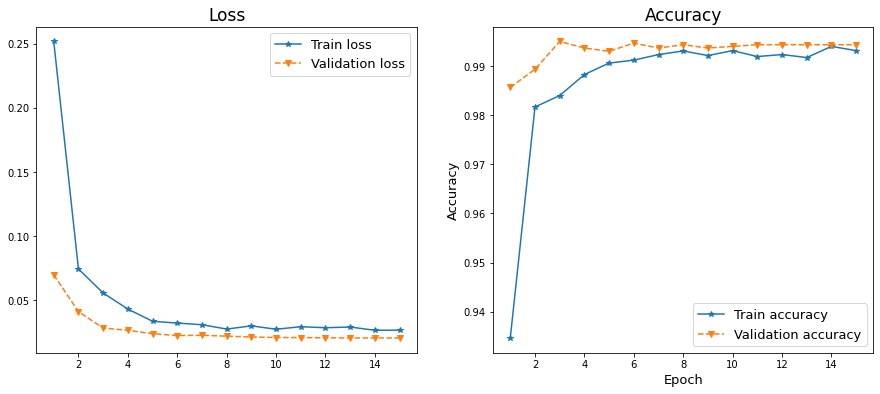

In [ ]:
plot_epoch_metric(train_losses, val_losses, train_acc, val_acc)

The comment to be made here is very similar to the previous one. Again, the model's accuracy value is better than train and validation. **Those with an F1 score of 1 are still the same classes.**

These:

**Bottle_Gourd, Carrot, Potato, Radish **are classes.

In the bad ones,** Brinjalin** f1 score decreased very little.** Papaya'**s remained the same.

In [ ]:
evaluate_test(model,test_dl,loss_fun,class_names)

Confusion Matrix:

[[200   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 198   0   0   0   0   0   0   0   1   0   0   1   0   0]
 [  0   0 200   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 197   0   0   0   0   0   2   1   0   0   0   0]
 [  0   0   0   0 199   1   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0 198   0   0   1   0   0   0   0   0   0]
 [  0   0   0   0   0   0 200   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 200   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 200   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   1 198   1   0   0   0   0]
 [  0   0   0   0   0   0   1   0   0   0 199   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 200   0   0   0]
 [  0   0   0   1   0   0   1   0   1   0   0   0 197   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 200   0]
 [  1   0   0   0   0   0   0   0   0   0   0   0   0   0 199]]

              precision    recall 

To compare the results of part1 with two hidden layers here, we have chosen the best accuracy in part1.

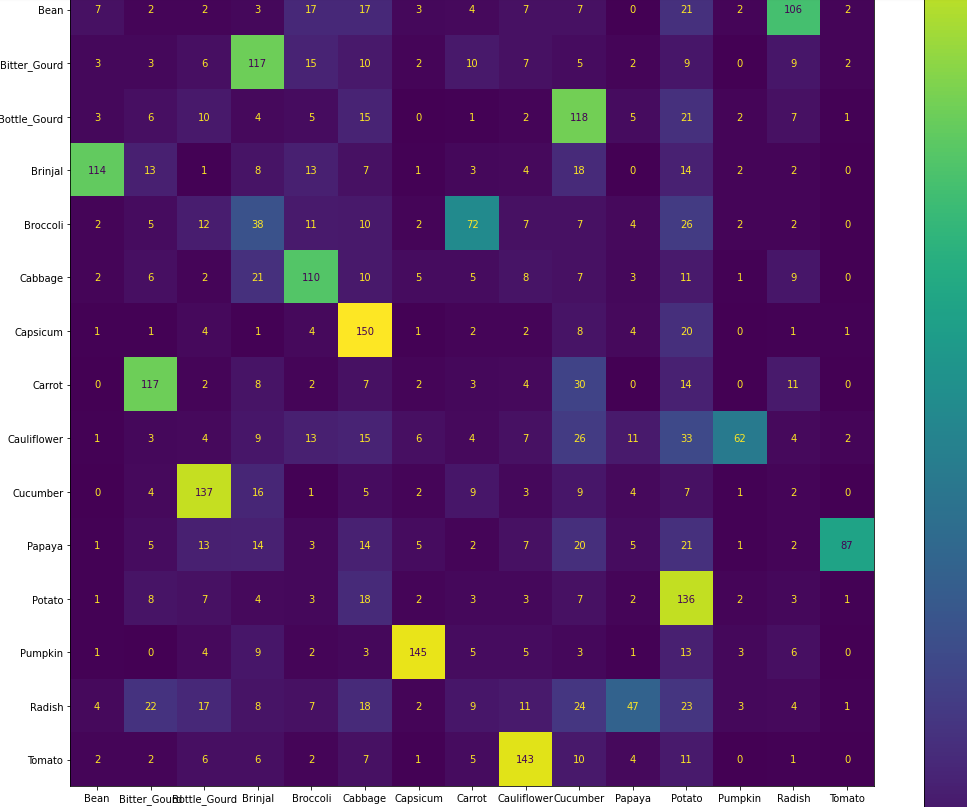

MLP model metrics:


```
              precision    recall  f1-score   support

           0      0.049     0.035     0.041       200
           1      0.015     0.015     0.015       200
           2      0.044     0.050     0.047       200
           3      0.030     0.040     0.034       200
           4      0.053     0.055     0.054       200
           5      0.033     0.050     0.040       200
           6      0.006     0.005     0.005       200
           7      0.022     0.015     0.018       200
           8      0.032     0.035     0.033       200
           9      0.030     0.045     0.036       200
          10      0.054     0.025     0.034       200
          11      0.358     0.680     0.469       200
          12      0.037     0.015     0.021       200
          13      0.024     0.020     0.022       200
          14      0.000     0.000     0.000       200

    accuracy                          0.072      3000
   macro avg      0.052     0.072     0.058      3000
weighted avg      0.052     0.072     0.058      3000

```



The confusion matrix seen above is the output of the model trained with 0.02 learning rate 16 batch size tanh+tanh activation functions. The result from all the model trained in VGG-19 are better than this one. This is because VGG-19 is a pretrained model. Also, our mlp model didn't perform well on validation and test data.